# Assessing Bathing Water Quality

## Import Libraries and Data

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import randint

from dtaidistance import dtw
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

## Combine Investigation and Statutory samples

In [ ]:
excel_path = 'BathingWaterVariables2023.xlsx' # Path to Excel file

# Load all required sheets into variables
inv_samples = pd.read_excel(excel_path, sheet_name='Investigation samples')
stat_samples = pd.read_excel(excel_path, sheet_name='Statutory samples')
rainfall = pd.read_excel(excel_path, sheet_name='Principle data')
tide = pd.read_excel(excel_path, sheet_name='Tide data')
stw_uv = pd.read_excel(excel_path, sheet_name='STW flow and UV')
seabird = pd.read_excel(excel_path, sheet_name='Seabird counts (total)')
MST = pd.read_excel(excel_path, sheet_name='MST Site 1')
uv_wind = pd.read_excel(excel_path, sheet_name='Ambient UV index and wind data')
add_data = pd.read_excel(excel_path, sheet_name='Additional data')

# Discharge sites
discharge_s1 = pd.read_excel(excel_path, sheet_name='Discharge site 1')
discharge_s2 = pd.read_excel(excel_path, sheet_name='Discharge site 2')
discharge_s3 = pd.read_excel(excel_path, sheet_name='Discharge site 3')
discharge_s4 = pd.read_excel(excel_path, sheet_name='Discharge site 4')
discharge_s5 = pd.read_excel(excel_path, sheet_name='Discharge site 5')
discharge_s6 = pd.read_excel(excel_path, sheet_name='Discharge site 6')
discharge_s7 = pd.read_excel(excel_path, sheet_name='Discharge site 7')
discharge_s8 = pd.read_excel(excel_path, sheet_name='Discharge site 8')
discharge_s9 = pd.read_excel(excel_path, sheet_name='Discharge site 9')

We need to clean investigation and statutory samples datasets before combining.

In [ ]:
# Replace instances of '<10' with 10
stat_samples[['Site 1 E_coli C-MF, NO/100ml', 'Site 1 IE Conf, CFU/0_1l']] = stat_samples[['Site 1 E_coli C-MF, NO/100ml', 'Site 1 IE Conf, CFU/0_1l']].replace('<10', 10)

# Get datetime column
stat_samples['GMT'] = stat_samples['GMT'].astype(str).str.zfill(4)
stat_samples['Time GMT'] = pd.to_datetime(stat_samples['GMT'], format='%H%M').dt.time

# Rename and drop columns
stat_samples.rename(columns={'date': 'Date', 'Site 1 E_coli C-MF, NO/100ml': 'Site 1 EC Inv', 'Site 1 IE Conf, CFU/0_1l': 'Site 1 IE Inv'}, inplace=True)
stat_samples.drop(['BST', 'GMT'], axis=1, inplace=True)

/var/folders/kb/813zvz8100df722sbg_m06vr0000gn/T/ipykernel_15106/2432708459.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  stat_samples[['Site 1 E_coli C-MF, NO/100ml', 'Site 1 IE Conf, CFU/0_1l']] = stat_samples[['Site 1 E_coli C-MF, NO/100ml', 'Site 1 IE Conf, CFU/0_1l']].replace('<10', 10)


In [ ]:
samples_combined.head()

,Date,Site 1 EC Inv,Site 1 IE Inv,Time GMT
0,2023-05-08,10,10,11:23:00
1,2023-05-15,10,10,11:04:00
2,2023-05-26,10,10,10:48:00
3,2023-05-29,45,10,10:46:00
4,2023-06-09,10,10,10:22:00


In [ ]:
# Combine dataframes
samples_combined = pd.concat([stat_samples, inv_samples], ignore_index=True)

# Ensure Date and Time GMT are strings
samples_combined['Date'] = samples_combined['Date'].astype(str)
samples_combined['Time GMT'] = samples_combined['Time GMT'].astype(str)

# Combine and convert to datetime
samples_combined['Date'] = pd.to_datetime(
    samples_combined['Date'] + ' ' + samples_combined['Time GMT']
)

# Drop unneccesary column
samples_combined = samples_combined.drop(columns=['Time GMT'])

samples_combined.head()

,Date,Site 1 EC Inv,Site 1 IE Inv
0,2023-05-08 11:23:00,10,10
1,2023-05-15 11:04:00,10,10
2,2023-05-26 10:48:00,10,10
3,2023-05-29 10:46:00,45,10
4,2023-06-09 10:22:00,10,10


# Random Forest Model

In this section, we build a random forest model to predict bacteria levels using various environmental variables.

## Rainfall

In [ ]:
rainfall['Date'] = pd.to_datetime(rainfall['Date'], format="%d/%m/%Y %H:%M", errors='coerce', dayfirst=True) # Convert date to datetime
rainfall = rainfall.dropna(subset=['Date']).set_index('Date').sort_index() # Drop missing values and set date as index

# Function to get last 24h of rainfall
def get_rainfall_24h(sample_time):
    window_start = sample_time - pd.Timedelta(hours=24)
    return rainfall.loc[window_start:sample_time]['RF mm (GMT)'].sum()

# Apply function to each sample
samples_combined['rainfall_24h'] = samples_combined['Date'].apply(get_rainfall_24h)

## Tide

In [ ]:
tide['Date'] = pd.to_datetime(tide['Date'], format='%d/%m/%Y %H:%M') # Convert date to datetime
tide.dropna(subset=['Date'], inplace=True)
tide = tide.sort_values('Date')  # Proper method for sorting

# Merge
samples_combined = pd.merge_asof(
    samples_combined.sort_values('Date'),  # must be sorted
    tide[['Date', 'Tide Astronomical (MaOD)']],
    on='Date',
    direction='nearest'
)

## STW Flow and UV Transmittence

In [ ]:
stw_uv['Date'] = pd.to_datetime(stw_uv['Date'], format="%d/%m/%Y %H:%M", dayfirst=True, errors='coerce') # Convert date to datetime
stw_uv = stw_uv.dropna(subset=['Date']).sort_values('Date') # Drop missing values and sort by date

# Merge
samples_combined = pd.merge_asof(
    samples_combined,
    stw_uv[['Date', 'Flow (l/s)', 'UV Transmittance 1']],
    on='Date',
    direction='nearest'
)

## Seabirds

In [ ]:
seabird['date'] = pd.to_datetime(seabird['date'], format='%d/%m/%Y') # Convert date to datetime
seabird['GMT'] = seabird['GMT'].astype(str).str.zfill(4) # Pad
seabird['Hour'] = seabird['GMT'].str[:2].astype(int) # Convert to hours
seabird['Minute'] = seabird['GMT'].str[2:].astype(int) # Convert to minutes
seabird['Date'] = seabird['date'] + pd.to_timedelta(seabird['Hour'], unit='h') + pd.to_timedelta(seabird['Minute'], unit='m') # Combine to single datetime
seabird = seabird.drop(columns=['Hour', 'Minute', 'date', 'BST', 'GMT']) # Drop unneccesary columns

# Merge
samples_combined = pd.merge_asof(
    samples_combined,
    seabird[['Date', 'Bird Counts']],
    left_on='Date',
    right_on='Date',
    direction='nearest',
)


## MST

In [ ]:
# Clean columns replacing N/F with small placeholder value
MST['Hubac log (10) Gene Copies / 100ml'] = MST['Hubac log (10) Gene Copies / 100ml'].replace('N/F', 0.5).astype(float)
MST['Dog log (10) Gene Copies / 100ml'] = MST['Dog log (10) Gene Copies / 100ml'].replace('N/F', 0.5).astype(float)

# Get date column
MST['GMT'] = MST['GMT'].astype(str).str.zfill(4) # Pad
MST['Hour'] = MST['GMT'].str[:2].astype(int) # Extract hour
MST['Minute'] = MST['GMT'].str[2:].astype(int) # Extract minute
MST['Date'] = pd.to_datetime(MST['Sample Date'], format="%d/%m/%Y") \
               + pd.to_timedelta(MST['Hour'], unit='h') \
               + pd.to_timedelta(MST['Minute'], unit='m')

# Keep relevant columns
MST_clean = MST[['Date',
                 'Hubac log (10) Gene Copies / 100ml',
                 'Dog log (10) Gene Copies / 100ml',
                 'Catmar log (10) Gene Copies / 100ml']].copy()

MST_clean = MST_clean.rename(columns={
    'Hubac log (10) Gene Copies / 100ml': 'HuBac',
    'Dog log (10) Gene Copies / 100ml': 'Dog',
    'Catmar log (10) Gene Copies / 100ml': 'Catmar'
})

MST_clean = MST_clean.sort_values('Date') # Sort by date

# Merge
samples_combined = pd.merge_asof(
    samples_combined,
    MST_clean,
    on='Date',
    direction='nearest',
)

/var/folders/kb/813zvz8100df722sbg_m06vr0000gn/T/ipykernel_15106/3942928321.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  MST['Hubac log (10) Gene Copies / 100ml'] = MST['Hubac log (10) Gene Copies / 100ml'].replace('N/F', 0.5).astype(float)
/var/folders/kb/813zvz8100df722sbg_m06vr0000gn/T/ipykernel_15106/3942928321.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  MST['Dog log (10) Gene Copies / 100ml'] = MST['Dog log (10) Gene Copies / 100ml'].replace('N/F', 0.5).astype(float)


## UV and Wind

In [ ]:
uv_wind['DateTimeGMT'] = pd.to_datetime(uv_wind['DateTimeGMT'], dayfirst=True, errors='coerce') # Convert to datetime
uv_wind = uv_wind.dropna(subset=['DateTimeGMT']).sort_values('DateTimeGMT') # Drop missing values and sort

# Merge
samples_combined = pd.merge_asof(
    samples_combined,
    uv_wind[['DateTimeGMT', 'UVIndex', 'Wind_Sp', 'Wind_Dir']],
    left_on='Date',
    right_on='DateTimeGMT',
    direction='nearest',  # or 'backward'
)

samples_combined.drop(columns=['DateTimeGMT'], inplace=True) # Drop unneccesary column

## Additional Data

In [ ]:
add_data['GMT'] = add_data['GMT'].astype(str).str.zfill(4) # Pad
add_data['Hour'] = add_data['GMT'].str[:2].astype(int) # Extract hour
add_data['Minute'] = add_data['GMT'].str[2:].astype(int) # Extract minute

# Create datetime field
add_data['Date'] = pd.to_datetime(add_data['date'], format="%d/%m/%Y") \
                    + pd.to_timedelta(add_data['Hour'], unit='h') \
                    + pd.to_timedelta(add_data['Minute'], unit='m')


add_data = add_data.sort_values('Date')
median_val = add_data['Suspened solids 105C, mg/l'].median()
add_data['Suspened solids 105C, mg/l'] = add_data['Suspened solids 105C, mg/l'].fillna(median_val) # Fill missing values with median

# Merge
samples_combined = pd.merge_asof(
    samples_combined,
    add_data[['Date', 'Temp water Cel', 'Suspened solids 105C, mg/l',
              'Bathers', 'Beach users (not bathers)', 'Salinity, ppt', 'Dogs']],
    on='Date',
    direction='nearest',
)

## Discharge Sites

In [ ]:
discharge_s9 = discharge_s9.rename(columns={'Date': 'Time stamp'}) # Clean column name

discharge_dfs = []
for i in range(1, 10):
    df = globals()[f'discharge_s{i}'].copy()  # Get each discharge dataframe
    df = df[df['Duration'].notna()]           # Keep only rows where Duration is not NaN
    df['Site'] = f'Site{i}'                   # Add a Site column
    df['Time stamp'] = pd.to_datetime(df['Time stamp'], format='%d/%m/%Y %H:%M')
    discharge_dfs.append(df)

all_discharge = pd.concat(discharge_dfs, ignore_index=True) # Combine all into one DataFrame

all_discharge = all_discharge.sort_values(by='Time stamp').reset_index(drop=True) # Sort by Timestamp
all_discharge = all_discharge[['Time stamp', 'Duration', 'Site']].copy()

# Pivot all_discharge to get each site's duration as a column
discharge_pivot = all_discharge.pivot_table(
    index='Time stamp',
    columns='Site',
    values='Duration',
    aggfunc='sum'
).reset_index()

# Rename columns
discharge_pivot.columns.name = None
discharge_pivot = discharge_pivot.rename(columns=lambda x: f"Discharge_{x}" if x != 'Time stamp' else 'Date')

samples_combined = pd.merge_asof(
    samples_combined.sort_values('Date'),
    discharge_pivot.sort_values('Date'),
    on='Date',
    direction='nearest'
)

for col in samples_combined.columns:
    if 'Discharge_Site' in col:
        samples_combined[col] = samples_combined[col].fillna(0)

# Total discharge from all sites
samples_combined['Total_Discharge'] = samples_combined[[col for col in samples_combined.columns if 'Discharge_Site' in col]].sum(axis=1)

In [ ]:
samples_combined.head()

,Date,Site 1 EC Inv,Site 1 IE Inv,rainfall_24h,Tide Astronomical (MaOD),Flow (l/s),UV Transmittance 1,Bird Counts,HuBac,Dog,...,Discharge_Site1,Discharge_Site2,Discharge_Site3,Discharge_Site4,Discharge_Site5,Discharge_Site6,Discharge_Site7,Discharge_Site8,Discharge_Site9,Total_Discharge
0,2023-05-08 11:23:00,10,10,0.2,-2.09,128.1758,61.392,3,3.01,2.00,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.100000
1,2023-05-15 11:04:00,10,10,3.2,1.12,140.72964,48.303,0,0.50,0.50,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667
2,2023-05-26 10:48:00,10,10,0.0,1.02,115.51646,49.597,50,0.50,2.52,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333
3,2023-05-29 10:46:00,45,10,0.0,1.22,148.21976,36.996,2,0.50,2.00,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333
4,2023-06-09 10:22:00,10,10,0.0,1.38,193.47689,42.589,30,0.50,2.00,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333


## Run model

Now that we have our environmental data and bacteria data combined, we can proceed by building the random forest model.

In [ ]:
# Define feature and target variables
features = [
    'rainfall_24h', 'Tide Astronomical (MaOD)', 'Flow (l/s)', 'UV Transmittance 1',
    'Bird Counts', 'HuBac', 'Dog', 'Catmar', 'UVIndex', 'Wind_Sp', 'Wind_Dir',
    'Temp water Cel', 'Suspened solids 105C, mg/l', 'Bathers', 'Beach users (not bathers)', 'Salinity, ppt',
    'Dogs', 'Discharge_Site1', 'Discharge_Site2', 'Discharge_Site3', 'Discharge_Site4', 'Discharge_Site5',
    'Discharge_Site6', 'Discharge_Site7', 'Discharge_Site8', 'Discharge_Site9', 'Total_Discharge'
]

X = samples_combined[features].fillna(0) # Features

# Target variables
y_ec = samples_combined['Site 1 EC Inv']
y_ie = samples_combined['Site 1 IE Inv']

/var/folders/kb/813zvz8100df722sbg_m06vr0000gn/T/ipykernel_15106/18991350.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = samples_combined[features].fillna(0) # Features


In [ ]:
# Split data into training and testing sets
X_train_ec, X_test_ec, y_train_ec, y_test_ec = train_test_split(X, y_ec, test_size=0.2, random_state=42)
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)

In [ ]:
# Get matrix of parameter values for grid search
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
# RF Model for EC
rf_ec = RandomForestRegressor(random_state=42)
random_search_ec = RandomizedSearchCV(
    estimator=rf_ec,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
random_search_ec.fit(X_train_ec, y_train_ec)
best_rf_ec = random_search_ec.best_estimator_

y_pred_ec = best_rf_ec.predict(X_test_ec)

print("R² score:", r2_score(y_test_ec, y_pred_ec))
print("RMSE:", np.sqrt(mean_squared_error(y_test_ec, y_pred_ec)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
R² score: 0.6543356661066428
RMSE: 80.87024020214382


In [ ]:
# RF Model for IE
rf_ie = RandomForestRegressor(random_state=42)
random_search_ie = RandomizedSearchCV(
    estimator=rf_ie,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)
random_search_ie.fit(X_train_ie, y_train_ie)
best_rf_ie = random_search_ie.best_estimator_

y_pred_ie = best_rf_ie.predict(X_test_ie)

print("R² score:", r2_score(y_test_ie, y_pred_ie))
print("RMSE:", np.sqrt(mean_squared_error(y_test_ie, y_pred_ie)))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
R² score: 0.22374374512938489
RMSE: 72.09639851993205


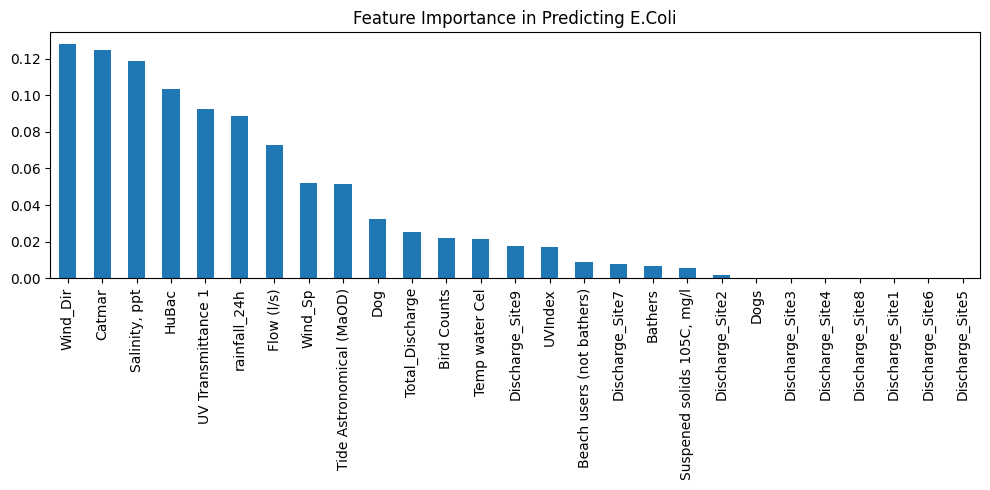

In [ ]:
# Feature Importance Bar Chart for EC
importances_ec = best_rf_ec.feature_importances_
feature_importance_ec = pd.Series(importances_ec, index=features).sort_values(ascending=False)

feature_importance_ec.plot(kind='bar', title='Feature Importance in Predicting E.Coli', figsize=(10, 5))
plt.tight_layout()
plt.show()

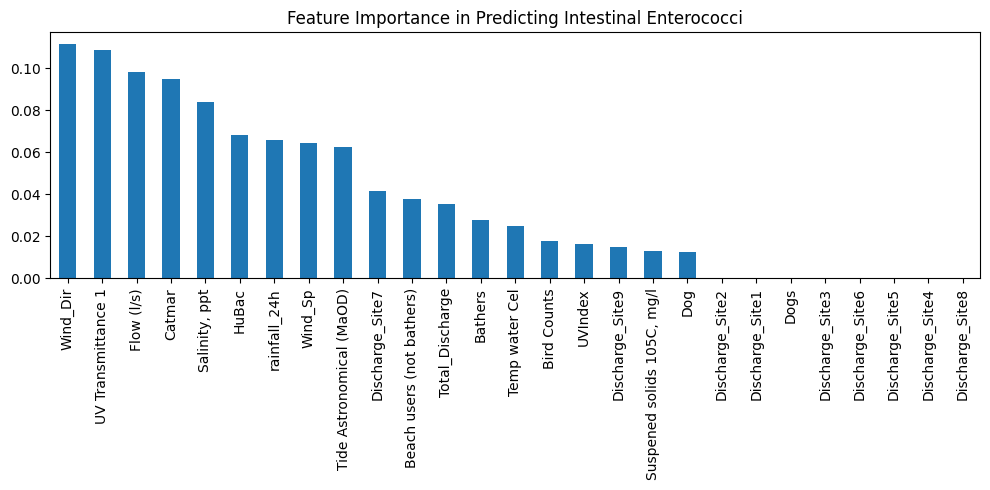

In [ ]:
# Feature Importance Bar Chart for IE
importances_ie = best_rf_ie.feature_importances_
feature_importance_ie = pd.Series(importances_ie, index=features).sort_values(ascending=False)

feature_importance_ie.plot(kind='bar', title='Feature Importance in Predicting Intestinal Enterococci', figsize=(10, 5))
plt.tight_layout()
plt.show()

In [ ]:
# Add new prediction columns
samples_combined['Pred_EC'] = best_rf_ec.predict(X)
samples_combined['Pred_IE'] = best_rf_ie.predict(X)

samples_combined.to_csv('bathing_water_model_output.csv', index=False) # Write to csv file

In [ ]:
samples_combined.head()

,Date,Site 1 EC Inv,Site 1 IE Inv,rainfall_24h,Tide Astronomical (MaOD),Flow (l/s),UV Transmittance 1,Bird Counts,HuBac,Dog,...,Discharge_Site3,Discharge_Site4,Discharge_Site5,Discharge_Site6,Discharge_Site7,Discharge_Site8,Discharge_Site9,Total_Discharge,Pred_EC,Pred_IE
0,2023-05-08 11:23:00,10,10,0.2,-2.09,128.1758,61.392,3,3.01,2.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.100000,0.100000,45.028090,79.398416
1,2023-05-15 11:04:00,10,10,3.2,1.12,140.72964,48.303,0,0.50,0.50,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.066667,0.066667,48.994382,71.689526
2,2023-05-26 10:48:00,10,10,0.0,1.02,115.51646,49.597,50,0.50,2.52,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,23.772472,47.532624
3,2023-05-29 10:46:00,45,10,0.0,1.22,148.21976,36.996,2,0.50,2.00,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,37.101124,48.113368
4,2023-06-09 10:22:00,10,10,0.0,1.38,193.47689,42.589,30,0.50,2.00,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.000000,0.033333,39.904494,72.629026


[CV] END max_depth=26, max_features=sqrt, min_samples_leaf=9, min_samples_split=5, n_estimators=902; total time=   2.2s
[CV] END max_depth=35, max_features=log2, min_samples_leaf=7, min_samples_split=5, n_estimators=338; total time=   0.9s
[CV] END max_depth=31, max_features=None, min_samples_leaf=9, min_samples_split=6, n_estimators=953; total time=   3.1s
[CV] END max_depth=46, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=391; total time=   1.2s
[CV] END max_depth=46, max_features=sqrt, min_samples_leaf=6, min_samples_split=3, n_estimators=391; total time=   1.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=807; total time=   2.5s
[CV] END max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=748; total time=   2.6s
[CV] END max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=7, n_estimators=311; total time=   1.1s
[CV] END max_depth=7, max_features=sqrt,

In [ ]:
# Write feature importances to csv file
feature_importance_ec.to_csv('FeatureImportanceEC.csv')
feature_importance_ie.to_csv('FeatureImportanceIE.csv')

In [ ]:
# Write R2 scores to csv file
r2_scores = pd.DataFrame({
    'EC Model': [r2_score(y_test_ec, y_pred_ec)],
    'IE Model': [r2_score(y_test_ie, y_pred_ie)],
})

r2_scores.to_csv('R2Scores.csv')

,EC Model,IE Model
0,0.659186,0.229196
